In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
path = '/content/drive/MyDrive/release_in_the_wild'
os.chdir(path)
print("Diretório atual:", os.getcwd())

Diretório atual: /content/drive/MyDrive/release_in_the_wild


Listing files...
Found 19999 real files and 17215 fake files.
Extracting LFCC features (may take a while)...


100%|██████████| 37214/37214 [2:43:29<00:00,  3.79it/s]


LFCC matrix shape: (37214, 40)
Training SVM baseline on LFCC means...
Saved SVM to /content/drive/MyDrive/modelos_deepfake/svm_lfcc.pkl

📊 SVM MFCC Evaluation Report
Accuracy: 1.0000
AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4000
        Fake       1.00      1.00      1.00      3443

    accuracy                           1.00      7443
   macro avg       1.00      1.00      1.00      7443
weighted avg       1.00      1.00      1.00      7443



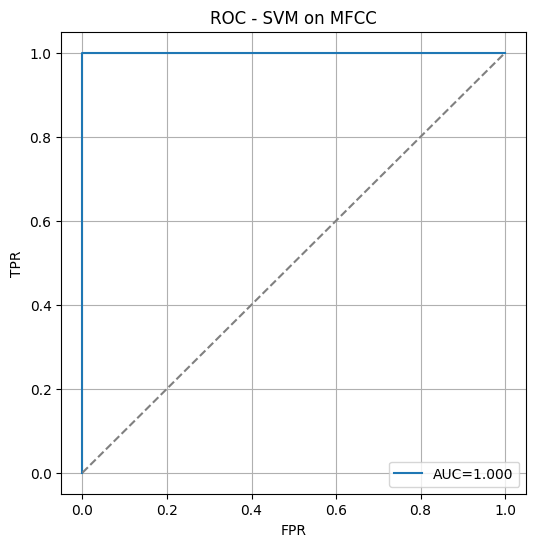

In [3]:
import os
import glob
import random
import numpy as np
import scipy.fft
import librosa
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report
)


# ---------- Configuration ----------
DATA_DIR = '/content/drive/MyDrive/release_in_the_wild'
SR = 16000
N_LFCC = 40
RANDOM_SEED = 42
MODEL_DIR = "/content/drive/MyDrive/modelos_deepfake"
os.makedirs(MODEL_DIR, exist_ok=True)
SVM_SAVE = os.path.join(MODEL_DIR, "svm_lfcc.pkl")
# -----------------------------------

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ---------- Utilities ----------
def list_audio_files(base_dir, exts=('.wav', '.flac', '.mp3')):
    """
    Lista todos os arquivos de áudio dentro das pastas 'real' e 'fake',
    percorrendo recursivamente todas as subpastas.

    Retorna:
        real_files, fake_files  ->  duas listas com caminhos completos
    """
    p_real = os.path.join(base_dir, "real")
    p_fake = os.path.join(base_dir, "fake")

    real_files = []
    fake_files = []

    # Percorre todas as subpastas de REAL
    if os.path.isdir(p_real):
        for root, _, files in os.walk(p_real):
            for f in files:
                if f.lower().endswith(exts):
                    file_path = os.path.join(root, f)
                    real_files.append(file_path)

    # Percorre todas as subpastas de FAKE
    if os.path.isdir(p_fake):
        for root, _, files in os.walk(p_fake):
            for f in files:
                if f.lower().endswith(exts):
                    file_path = os.path.join(root, f)
                    fake_files.append(file_path)

    return real_files, fake_files


def load_audio(path, sr=SR):
    wav, fs = sf.read(path)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if fs != sr:
        wav = librosa.resample(wav.astype(np.float32), orig_sr=fs, target_sr=sr)
    return wav.astype(np.float32)

def linear_filter_banks(sr, n_fft, n_filters, fmin=0, fmax=None):
    if fmax is None:
        fmax = sr / 2

    # Frequências reais geradas pela FFT
    freqs = np.linspace(0, sr / 2, 1 + n_fft // 2)

    # Bordas das bandas lineares
    edges = np.linspace(fmin, fmax, n_filters + 2)

    fbanks = np.zeros((n_filters, len(freqs)))

    for i in range(n_filters):
        left = edges[i]
        center = edges[i + 1]
        right = edges[i + 2]

        # Subida triangular
        left_slope = (freqs - left) / (center - left)
        # Descida triangular
        right_slope = (right - freqs) / (right - center)

        fbanks[i] = np.maximum(0, np.minimum(left_slope, right_slope))

    return fbanks


# ---------------------------------------
# 2. Função para extrair LFCC completo
# ---------------------------------------
def extract_lfcc(wave, sr=16000, n_lfcc=40):
    # STFT → power spectrum
    S = np.abs(librosa.stft(wave, n_fft=512, hop_length=160, win_length=400))**2

    # Filtros triangulares lineares
    fbanks = linear_filter_banks(sr=sr, n_fft=512, n_filters=n_lfcc)

    # Aplica os filtros → espectro filtrado
    filtered = np.dot(fbanks, S)

    # log-energy
    logS = np.log(filtered + 1e-10)

    # Cepstrum via DCT
    lfcc = scipy.fft.dct(logS, axis=0, norm="ortho")

    return lfcc


# ---------------------------------------
# 3. LFCC mean (vetor fixo)
# ---------------------------------------
def extract_lfcc_mean(wave, sr=16000, n_lfcc=40):
    lfcc = extract_lfcc(wave, sr=sr, n_lfcc=n_lfcc)
    return np.mean(lfcc, axis=1)

# ---------- Build dataset ----------
print("Listing files...")
real_files, fake_files = list_audio_files(DATA_DIR)
print(f"Found {len(real_files)} real files and {len(fake_files)} fake files.")

files = [(p, 0) for p in real_files] + [(p, 1) for p in fake_files]
random.shuffle(files)

mfcc_X, labels = [], []
print("Extracting LFCC features (may take a while)...")
for path, lbl in tqdm(files):
    try:
        wav = load_audio(path)
        mf = extract_lfcc_mean(wav)
        mfcc_X.append(mf)
        labels.append(lbl)
    except Exception as e:
        print("Failed on", path, e)

mfcc_X = np.vstack(mfcc_X)
labels = np.array(labels)
print("LFCC matrix shape:", mfcc_X.shape)

# ---------- Train & Save SVM ----------
print("Training SVM baseline on LFCC means...")
X_train, X_test, y_train, y_test = train_test_split(
    mfcc_X, labels, test_size=0.2, stratify=labels, random_state=RANDOM_SEED
)
svm = SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_SEED)
svm.fit(X_train, y_train)

# Save model
joblib.dump(svm, SVM_SAVE)
print("Saved SVM to", SVM_SAVE)

# ---------- Load model & Evaluate ----------
svm = joblib.load(SVM_SAVE)
y_pred = svm.predict(X_test)
y_score = svm.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_score)

print("\n📊 SVM MFCC Evaluation Report")
print("================================")
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

# ---------- Plot ROC ----------
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - SVM on MFCC")
plt.legend()
plt.grid(True)
plt.show()